In [83]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 08 18:31:15 2015

@author: alsherman
"""
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

import matplotlib
%matplotlib inline

# Read Data

In [31]:
train_data = r'https://raw.githubusercontent.com/Alexjmsherman/DataScience_GeneralAssembly/master/Data/train.csv'
test_data =  r'https://raw.githubusercontent.com/Alexjmsherman/DataScience_GeneralAssembly/master/Data/test.csv'
            
train = pd.read_table(train_data, sep=',')
test = pd.read_table(test_data, sep=',')

data = train.append(test)

In [4]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


# Data Exploration

In [25]:
# Explore the data to indtify trends in characteristics of survivors
data.Survived.value_counts()                    # How many people lived and died
data.Survived.mean()                            # The survival rate for everyone
data.groupby('Sex').Survived.mean()             # By Sex: women have higher survival rates
data.groupby('Sex').Pclass.count()
data.groupby(['Sex','Pclass']).count()
data.groupby('Pclass').Survived.mean()          # By Pclass: 1st class passengers have higher survival rates
data.groupby(['Sex', 'Pclass']).Survived.mean() # By Sex and Pclass: Women in the 1st and 2nd classes had the highest survival rates

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000039BB160>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000B4869E8>], dtype=object)

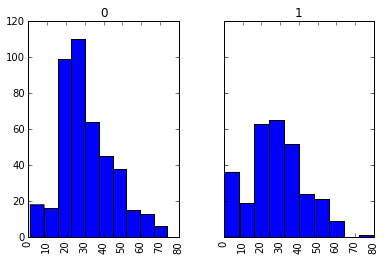

In [9]:
train.Age.hist(by=train.Survived, sharex=True, sharey=True)

# Impute Missing Values

In [27]:
data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

###  Missing Values in Age Column

In [32]:
#Extract Title to use to calculate missing Age values
data['Title'] = [name.split(',')[1].split('.')[0] for name in data.Name]
set(data.Title) #List the unique titles

{' Capt',
 ' Col',
 ' Don',
 ' Dona',
 ' Dr',
 ' Jonkheer',
 ' Lady',
 ' Major',
 ' Master',
 ' Miss',
 ' Mlle',
 ' Mme',
 ' Mr',
 ' Mrs',
 ' Ms',
 ' Rev',
 ' Sir',
 ' the Countess'}

In [6]:
#Calculate the % of missing Age values, grouped by Sex, Pclass, and Title
data.groupby(['Sex', 'Pclass','Title']).Age.apply(lambda x: x.isnull().sum()) / data.groupby(['Sex', 'Pclass','Title']).Age.count()

Sex     Pclass  Title        
female  1        Dona            0.000000
                 Dr              0.000000
                 Lady            0.000000
                 Miss            0.016949
                 Mlle            0.000000
                 Mme             0.000000
                 Mrs             0.149254
                 the Countess    0.000000
        2        Miss            0.041667
                 Mrs             0.018519
                 Ms              0.000000
        3        Miss            0.456311
                 Mrs             0.326531
                 Ms                   inf
male    1        Capt            0.000000
                 Col             0.000000
                 Don             0.000000
                 Dr              0.250000
                 Jonkheer        0.000000
                 Major           0.000000
                 Master          0.000000
                 Mr              0.204545
                 Sir             0.000000
    

In [7]:
data.groupby(['Sex','Pclass','Title']).Age.mean()

Sex     Pclass  Title        
female  1        Dona            39.000000
                 Dr              49.000000
                 Lady            48.000000
                 Miss            30.338983
                 Mlle            24.000000
                 Mme             24.000000
                 Mrs             43.208955
                 the Countess    33.000000
        2        Miss            20.717083
                 Mrs             33.518519
                 Ms              28.000000
        3        Miss            17.360874
                 Mrs             32.326531
                 Ms                    NaN
male    1        Capt            70.000000
                 Col             54.000000
                 Don             40.000000
                 Dr              44.750000
                 Jonkheer        38.000000
                 Major           48.500000
                 Master           6.984000
                 Mr              41.450758
                 Sir    

Third class passengers are most likely to have missing values for age
as well Mr, Mrs, and Doctor in first class

these mean values change alot by title in each class - as much ass ten years
-group by Sex, Pclass, and Title to account for these changes in age

In [33]:
#Fill in Missing values with the mean of passengers with the same Sex, Pclass, and Title
fill_mean = lambda g: g.fillna(g.mean())
data.Age = data.groupby(['Sex', 'Pclass','Title']).transform(fill_mean)['Age']                                                     

# Feature Extraction

Ideas for later:
-group families - passengers with the same last name (in the Name Field) and same sum for Parch+SibSp (same # of people on-board) 
-Extract Ticket code

In [ ]:
# Create a proxy variable representing whether the Spouse was on board
d['Spouse'] = ((d.Age > 18) & (d.SibSp >= 1)).astype(int)
d.Spouse.value_counts()
d.groupby(['Pclass', 'Spouse']).Survived.mean() # Having a spouse appears to increase survival in the 1st class only

In [5]:
data['binned_age'] = [age - age%10 for age in data.Age ]

# Models

In [36]:
data[0:1]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22,NaN,S,7.25,"Braund, Mr. Owen Harris",0,1,3,0,1,0,A/5 21171,Mr


I will need to transform the following variables:
Cabin
Embarked
Name - I will leave this off the model for now
Sex
Ticket
Title

In [35]:
# Convert all variables to numeric so for scikit learn
data['Sex'] = np.where(data.Sex == 'female', 1, 0)

In [39]:
#subset training data for model creation
print len(train) #determine length of original train data set and use that to subset 'data'
training = data[0:891]

891


### KNN

In [60]:
# Step 1 Split the data into training and testing data sets
X = training.drop(['Survived','Embarked','Cabin','Name','Ticket','Title'], axis=1)
y = training['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

In [115]:
# Step 2: train the model on the training set (using K=25)
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=25, p=2, weights='uniform')

In [116]:
# Step 3: test the model on the testing set, and check the accuracy
y_pred = knn.predict(X_test)
print metrics.accuracy_score(y_test, y_pred)

0.641791044776


### Decision Tree

In [118]:
# Create a decision tree classifier instance (start out with a small tree for interpretability)
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=3)

# Fit the decision tree classider
ctree.fit(X_train, y_train)

# Create a feature vector
features = X_train.columns.tolist()

# Which features are the most important?
pd.DataFrame(zip(features, ctree.feature_importances_)).sort_index(by=1, ascending=False)


,0,1
5,Sex,0.610247
4,Pclass,0.189453
0,Age,0.087655
6,SibSp,0.070977
1,Fare,0.041667
2,Parch,0.000000
3,PassengerId,0.000000


In [112]:
# Make predictions on the test set
y_pred = ctree.predict(X_test)

# Calculate accuracy
metrics.accuracy_score(y_test, y_pred)

0.79104477611940294

In [112]:
test2 = data[892:]

In [113]:
X = test2.drop(['Age','Survived','Embarked','Cabin','Name','Sex','Ticket','Title','binned_age'], axis=1)

In [114]:
X = X.fillna(28)

In [115]:
y_pred = knn.predict(X)

In [120]:
test2['prediction'] = y_pred

In [121]:
submit = test2['Survived']

#submit.columns = [['PassengerId','Survived']]

In [118]:
submit = pd.DataFrame(submit)
submit['Survived'] = [0 if i != 1 else 1 for i in submit.Survived]

In [110]:
submit.to_csv(r'C:\Users\alsherman\Desktop\GitHub\DataScience_GeneralAssembly\Data\submit.csv')

In [ ]:


'''

Split into training and test datasets, and build the model

'''

# Now, split the data into training and test sets
train, test = train_test_split(d,test_size=0.3, random_state=1)

# Convert them back into dataframes, for convenience
train = pd.DataFrame(data=train, columns=d.columns)
test = pd.DataFrame(data=test, columns=d.columns)

# Create a decision tree classifier instance (start out with a small tree for interpretability)
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=3)

# Fit the decision tree classider
ctree.fit(train.drop('Survived', axis=1), train['Survived'])

# Create a feature vector
features = d.columns.tolist()[1:]




# How to interpret the diagram?
ctree.classes_

# Predict what will happen for 1st class woman
features
ctree.predict_proba([1, 1, 25, 0, 0, 0])
ctree.predict([1, 1, 25, 0, 0, 0])

# Predict what will happen for a 3rd class man
ctree.predict_proba([3, 0, 25, 0, 0, 0])

# Which features are the most important?
# See "..other/calculating_cart_importance_measures.xlsx" for a detailed example
ctree.feature_importances_

# Clean up the output
pd.DataFrame(zip(features, ctree.feature_importances_)).sort_index(by=1, ascending=False)

# Make predictions on the test set
preds = ctree.predict(test.drop('Survived', axis=1))

# Calculate accuracy
metrics.accuracy_score(test['Survived'], preds)

# Confusion matrix
pd.crosstab(test['Survived'], preds, rownames=['actual'], colnames=['predicted'])

# Make predictions on the test set using predict_proba
probs = ctree.predict_proba(test.drop('Survived', axis=1))[:,1]

# Calculate the AUC metric
metrics.roc_auc_score(test['Survived'], probs)

'''

FINE-TUNING THE TREE

'''
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

y = d['Survived'].values
X = d[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Spouse']].values

# check CV score for max depth = 3
ctree = tree.DecisionTreeClassifier(max_depth=3)
np.mean(cross_val_score(ctree, X, y, cv=5, scoring='roc_auc'))

# check CV score for max depth = 10
ctree = tree.DecisionTreeClassifier(max_depth=10)
np.mean(cross_val_score(ctree, X, y, cv=5, scoring='roc_auc'))

# Conduct a grid search for the best tree depth
ctree = tree.DecisionTreeClassifier(random_state=1, min_samples_leaf=20)
depth_range = range(1, 20)
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(ctree, param_grid, cv=5, scoring='roc_auc')
grid.fit(X, y)

# Check out the scores of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]

# Plot the results of the grid search
plt.figure()
plt.plot(depth_range, grid_mean_scores)
plt.hold(True)
plt.grid(True)
plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

# Get the best estimator
best = grid.best_estimator_

# Plot the best estimator
with open("titanic_best.dot", 'w') as f:
    f = tree.export_graphviz(best, out_file=f, feature_names=features, close=True)